In [59]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance

In [1]:
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl

Processing /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl


In [2]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image

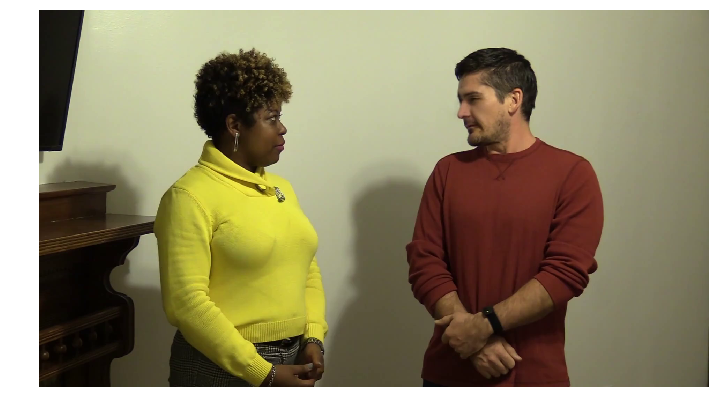

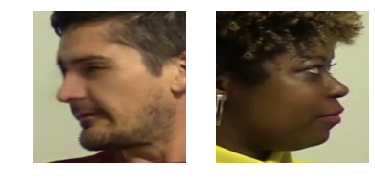

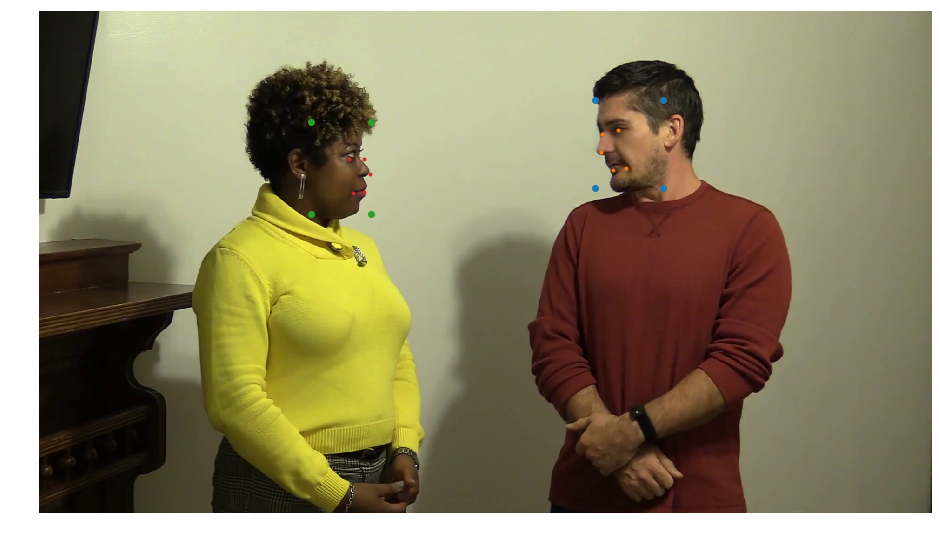

In [10]:
# Create face detector
mtcnn = MTCNN(margin=40, keep_all=True, post_process=False) #, device='cuda:0')

# Load a single image and display
v_cap = cv2.VideoCapture('/kaggle/input/deepfake-detection-challenge/train_sample_videos/avibnnhwhp.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

faces = mtcnn(frame)

# Visualize
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

322.62555 17.853294 432.5588 124.45829
174.32843 59.92434 221.46596 120.72124
53.44815 97.03937 95.28967 150.72708
1.4098953 140.3239 34.214558 178.16846
8.481639 70.91008 24.676332 92.68726


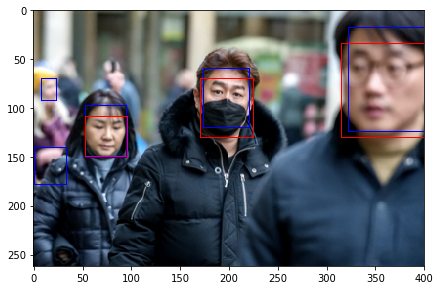

In [26]:
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.resize(img, (1920, 1080))

faces, _, _ = mtcnn.detect(img, landmarks=True)

for (x1, y1, x2, y2) in faces:
    print(x1, y1, x2, y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
    # break

with open('../input/face-mask-detection/annotations/maksssksksss244.xml') as fd:
    temp = np.atleast_1d(xmltodict.parse(fd.read())["annotation"]["object"])

for t in temp:
    bbox = t['bndbox']
    xmin = int(bbox['xmin'])
    ymin = int(bbox['ymin'])
    xmax = int(bbox['xmax'])
    ymax = int(bbox['ymax'])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(img)

## Face detecting model

In [ ]:
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

### Face detecting example

In [ ]:
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

for (x, y, w, h) in faces:
    cv2.rectangle(out_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(7, 7))
plt.imshow(out_img)

## VGG19 for mask/no mask classification

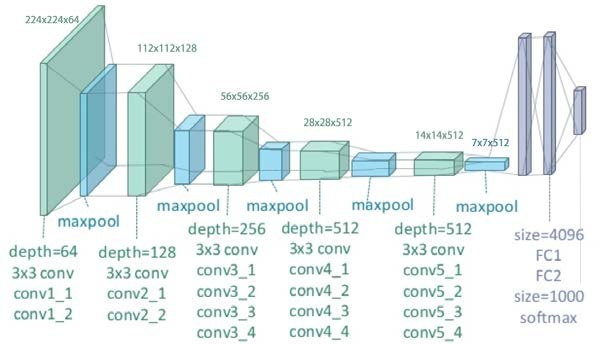

**Paper** : [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [31]:
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

### The model was pretrained on ImageNet dataset

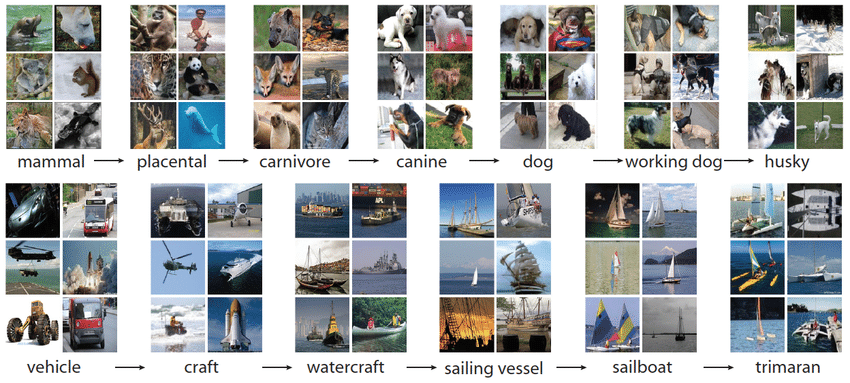

In [42]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [43]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Training on images of faces

In [35]:
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

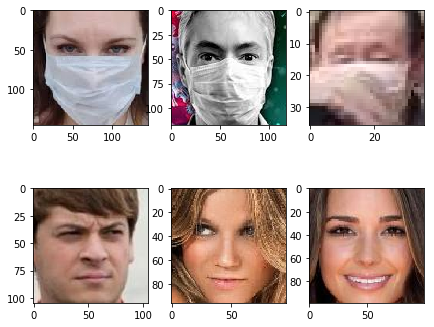

In [39]:
train_dataset_path = Path('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train')

imgs = [cv2.imread(str(train_dataset_path / x)) for x in ['WithMask/1025.png',
                                                          'WithMask/1045.png',
                                                          'WithMask/19.png',
                                                          'WithoutMask/1273.png',
                                                          'WithoutMask/1274.png',
                                                          'WithoutMask/283.png']]
imgs = [cv2.cvtColor(x, cv2.COLOR_RGB2BGR) for x in imgs]

col_num = 3
row_num = int(np.ceil(len(imgs) / col_num))
fig, ax = plt.subplots(row_num, col_num, figsize=(7, row_num * 3))
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)

In [40]:
# Augment training data
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(128, 128),
                                                   class_mode='categorical',
                                                   batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [44]:
batch_size = 32
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator) // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=len(val_generator) // batch_size)

Epoch 1/20
8/9 [=========================>....] - ETA: 3s - loss: 0.5171 - accuracy: 0.7461

KeyboardInterrupt: 

In [45]:
model.evaluate(test_generator)

 6/25 [======>.......................] - ETA: 1:11

KeyboardInterrupt: 

### Testing on test data

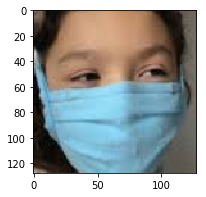

In [46]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img, (128, 128))

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(sample_mask_img, cv2.COLOR_RGB2BGR))

In [47]:
sample_mask_img = np.reshape(sample_mask_img,[1, 128, 128, 3])
sample_mask_img = sample_mask_img / 255.0

model.predict(sample_mask_img, verbose=0)[0]

array([0.14074023, 0.15275499], dtype=float32)

### Saving the model

In [ ]:
model.save('/kaggle/working/masknet.h5')

In [ ]:
model = keras.models.load_model('/kaggle/working/masknet.h5')

## Haar Cascade Model for face detecting + VGG19 for mask classification                    

In [48]:
mask_label = {0:'MASK',1:'NO MASK'}
color = {0: (0,255,0), 1: (255,0,0)}

In [49]:
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

for (x,y,w,h) in faces:
    crop = new_img[y: y+h, x: x+w]
    crop = cv2.resize(crop, (128, 128))
    crop = np.reshape(crop,[1, 128, 128, 3]) / 255.0
    mask_result = model.predict(crop, verbose=0)
    cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                color[mask_result.argmax()], 2)
    cv2.rectangle(new_img, (x, y), (x + w, y + h), color[mask_result.argmax()], 1)

plt.figure(figsize=(7, 7))
plt.imshow(new_img)

NameError: name 'face_model' is not defined

### Evaluation on Face Mask Detection dataset

### Extraction of Images and Annotations

In [50]:
!pip install xmltodict

import xmltodict

In [51]:
from collections import Counter
from glob import glob

In [52]:
listing=[]
for p in glob('/kaggle/input/face-mask-detection/annotations/*.xml'):
    with open(p) as fd:
        temp = np.atleast_1d(xmltodict.parse(fd.read())["annotation"]["object"])

    for i in range(len(temp)):
        listing.append(temp[i]["name"])

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n', values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


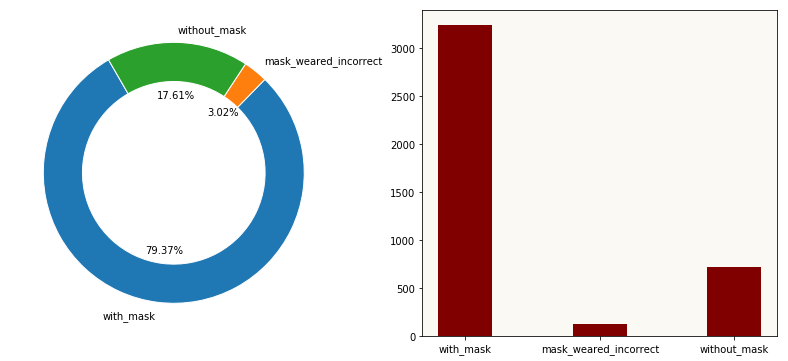

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values, wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

In [ ]:
category_id = {'with_mask': 0, 'without_mask': 1}

gt_annotations = {}
gt_annotations["categories"] = [
    {
      "id": 0,
      "name": "with_mask",
      "supercategory": ""
    },
    {
      "id": 1,
      "name": "without_mask",
      "supercategory": ""
    }
]
gt_annotations["licenses"] = []
gt_annotations['annotations'] = []
gt_annotations['images'] = []
gt_annotations["info"] = {
    "contributor": "",
    "description": "",
    "url": "",
    "date_created": "",
    "version": "",
    "year": 0
}


pred_annotations = []

gt_id = 1
pred_id = 1
img_id = 1


for p in glob('/kaggle/input/face-mask-detection/images/*.png')[:20]:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    
    p = Path(p)
    pa = '/kaggle/input/face-mask-detection/annotations/' + p.stem + '.xml'
    with open(pa) as fd:
        xml_annotation = xmltodict.parse(fd.read())["annotation"]
        img_size = xml_annotation['size']
        temp = np.atleast_1d(xml_annotation["object"])
        
    if np.any([t['name'] == 'mask_weared_incorrect' for t in temp]):  # Skip image
        continue
        
    # Ground Truth annotations
    for t in temp:
        bbox = t['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        gt_annotations['annotations'].append({'id': gt_id,
                                              'image_id': img_id,
                                              'category_id': category_id[t['name']],
                                              'bbox': [xmin, ymin, xmax, ymax]})
        print(t['name'], [xmin, ymin, xmax, ymax])
        gt_id += 1
        
    gt_annotations['images'].append({
        "width": img_size['width'],
        "height": img_size['height'],
        "flickr_url": "",
        "coco_url": "",
        "file_name": p.name,
        "date_captured": 0,
        "license": 0,
        "id": img_id
    })
    img_id += 1
    
    
    # Predicted annotations
    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    plt.figure(figsize=(7, 7))
    plt.imshow(new_img)
    
    for (x, y, w, h) in faces:
        crop = new_img[y: y + h, x: x + w]
        crop = cv2.resize(crop, (128, 128))
        crop = np.reshape(crop,[1, 128, 128, 3]) / 255.0
        mask_result = model.predict(crop, verbose=0)
        
        xmin = int(x)
        ymin = int(y)
        xmax = xmin + int(w)
        ymax = ymin + int(h)
        pred_annotations.append({'id': pred_id,
                                 'image_id': img_id,
                                 'category_id': int(mask_result.argmax()),
                                 'bbox': [xmin, ymin, xmax, ymax],
                                 'score': float(mask_result.max())})
        print(mask_result.argmax(), round(mask_result.max(), 2), [xmin, ymin, xmax, ymax])
        pred_id += 1
        
    print()


with open('/kaggle/working/gt_annotations.json', 'w') as f:
    json.dump(gt_annotations, f, indent=4)

with open('/kaggle/working/pred_annotations.json', 'w') as f:
    json.dump(pred_annotations, f, indent=4)

In [65]:
category_id = {'with_mask': 0, 'without_mask': 1}

gt_annotations = {}
gt_annotations["categories"] = [
    {
      "id": 0,
      "name": "with_mask",
      "supercategory": ""
    },
    {
      "id": 1,
      "name": "without_mask",
      "supercategory": ""
    }
]
gt_annotations["licenses"] = []
gt_annotations['annotations'] = []
gt_annotations['images'] = []
gt_annotations["info"] = {
    "contributor": "",
    "description": "",
    "url": "",
    "date_created": "",
    "version": "",
    "year": 0
}


pred_annotations = []

gt_id = 1
pred_id = 1
img_id = 1


for p in glob('/kaggle/input/face-mask-detection/images/*.png'):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    p = Path(p)
    pa = '/kaggle/input/face-mask-detection/annotations/' + p.stem + '.xml'
    with open(pa) as fd:
        xml_annotation = xmltodict.parse(fd.read())["annotation"]
        img_size = xml_annotation['size']
        temp = np.atleast_1d(xml_annotation["object"])
        
    if np.any([t['name'] == 'mask_weared_incorrect' for t in temp]):  # Skip image
        continue
        
    # Ground Truth annotations
    for t in temp:
        bbox = t['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        gt_annotations['annotations'].append({'id': gt_id,
                                              'image_id': img_id,
                                              'category_id': 0,  # category_id[t['name']],
                                              'bbox': [xmin, ymin, xmax, ymax]})
        # print(t['name'], [xmin, ymin, xmax, ymax])
        gt_id += 1
        
    gt_annotations['images'].append({
        "width": img_size['width'],
        "height": img_size['height'],
        "flickr_url": "",
        "coco_url": "",
        "file_name": p.name,
        "date_captured": 0,
        "license": 0,
        "id": img_id
    })
    img_id += 1
    
    
    # Predicted annotations
    faces, probs, _ = mtcnn.detect(img, landmarks=True)
    if faces is None:
        continue
    
    for (x1, y1, x2, y2), prob in zip(faces, probs):
        x1 = int(max(x1, 0))
        y1 = int(max(y1, 0))
        x2 = int(min(x2, img.shape[1]))
        y2 = int(min(y2, img.shape[0]))
        # print([x1, y1, x2, y2])
        crop = img[y1: y2, x1: x2]
        crop = cv2.resize(crop, (128, 128))
        crop = np.reshape(crop,[1, 128, 128, 3]) / 255.0
        mask_result = model.predict(crop, verbose=0)
        
        pred_annotations.append({'id': pred_id,
                                 'image_id': img_id,
                                 'category_id': 0,  # int(mask_result.argmax()),
                                 'bbox': [x1, y1, x2, y2],
                                 'score': float(prob * 1)})  # float(prob * mask_result.max())})
        # print(mask_result.argmax(), round(mask_result.max(), 2))
        pred_id += 1
        
    # print()


with open('/kaggle/working/gt_annotations.json', 'w') as f:
    json.dump(gt_annotations, f, indent=4)

with open('/kaggle/working/pred_annotations.json', 'w') as f:
    json.dump(pred_annotations, f, indent=4)

In [77]:
!pip uninstall torch -y

Uninstalling torch-1.3.0:
  Successfully uninstalled torch-1.3.0


In [2]:
!pip install object_detection_metrics

  Created wheel for object-detection-metrics: filename=object_detection_metrics-0.1-cp36-none-any.whl size=7783 sha256=48d8a287db33a4b4838f10bfd4d28e616e630b4532de139f566d032163f79c97
  Stored in directory: /root/.cache/pip/wheels/7d/70/73/55050c37c6506b98807687506eda3a3bc7d11d9cd2256be4da
Successfully built object-detection-metrics


In [3]:
from podm.metrics import get_pascal_voc_metrics, MetricPerClass, get_bounding_boxes
from podm.box import Box, intersection_over_union
from podm import coco_decoder
from podm.metrics import MetricPerClass

ModuleNotFoundError: No module named 'podm.metrics'

In [ ]:
with open('/kaggle/input/cococo/gt_annotations.json') as fp:
    gold_dataset = coco_decoder.load_true_object_detection_dataset(fp)
with open('/kaggle/input/cococo/pred_annotations.json') as fp:
    pred_dataset = coco_decoder.load_pred_object_detection_dataset(fp, gold_dataset)

gt_BoundingBoxes = get_bounding_boxes(gold_dataset)
pd_BoundingBoxes = get_bounding_boxes(pred_dataset)
results = get_pascal_voc_metrics(gt_BoundingBoxes, pd_BoundingBoxes, .5)

In [ ]:
for cls, metric in results.items():
    print('Class', cls)
    label = metric.label
    print('ap', metric.ap)
    # print('precision', metric.precision)
    # print('interpolated_recall', metric.interpolated_recall)
    # print('interpolated_precision', metric.interpolated_precision)
    print('tp', metric.tp)
    print('fp', metric.fp)
    print('num_groundtruth', metric.num_groundtruth)
    print('num_detection', metric.num_detection)
    print()

In [ ]:
mAP = MetricPerClass.mAP(results)
mAP

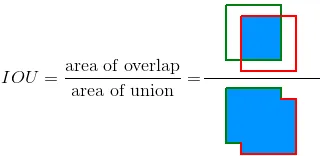

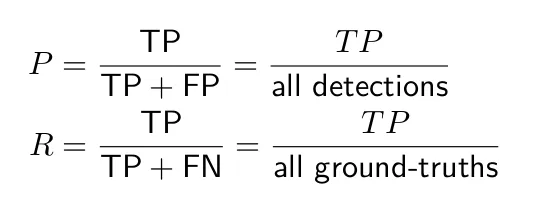

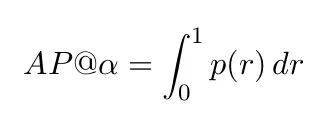

https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e

https://medium.com/@vijayshankerdubey550/evaluation-metrics-for-object-detection-algorithms-b0d6489879f3